# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

The paper is available on [arXiv](https://arxiv.org/abs/2010.11929). In creating the interactive material for this notebook, we utilized the models checkpoints available on the [official repository](https://github.com/google-research/vision_transformer#vision-transformer-and-mlp-mixer-architectures).

------------------------------------------------------------------------

# Goals

The objective of this notebook is to show you how to:

-   Critically analyze the qualitative and quantitative claims in the research paper
-   Specify the experiments that are required to verify each claim
-   Identify the data, code, and hyperparameters that are necessary to run each experiment
-   Use pretrained models to validate claims that need high computational resources
-   Determine the feasibility of verifying different types of claims
-   Design new experiments to validate the qualitative claims when some models or datasets are unavailable

**To assess the reproducibility level of this paper, we need to answer some questions while experimenting:**

-   Is there code available for both training and inference stages?
-   Is the code written by the authors themselves, or by someone else? Are there multiple implementations available for comparison?
-   What framework and version was used by the authors? Are all the functions still available or do we need to make some modifications?
-   Did the authors compare their model to other models that are not implemented in the code? Are these models available elsewhere?
-   Are all the hyperparameters for all the experiments clearly specified? If not, how sensitive is each hyperparameter to the performance?
-   Were the initial values set randomly or deterministically?
-   Are the datasets used by the authors accessible? Are there any preprocessing steps or modifications done to the data?
-   Did we obtain the same results as reported in the original paper?

# Introduction

The paper *“An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”* by Dosovitskiy et al. introduces a novel way of applying the [transformer architecture](https://arxiv.org/abs/1706.03762), which was originally designed for natural language processing, to computer vision tasks. Unlike previous works that combine or modify [convolutional neural networks (CNNs)](https://arxiv.org/abs/1511.08458) with transformers, the authors propose to use transformers directly on images, without any CNNs involved. They split an image into a sequence of patches, and feed their embeddings to a transformer encoder, which produces a feature vector for each patch. They use the feature vector of a special classification token as the image representation, and add a classification head on top of it. They name this model the [**Vision Transformer (ViT)**](https://arxiv.org/abs/2010.11929).

| 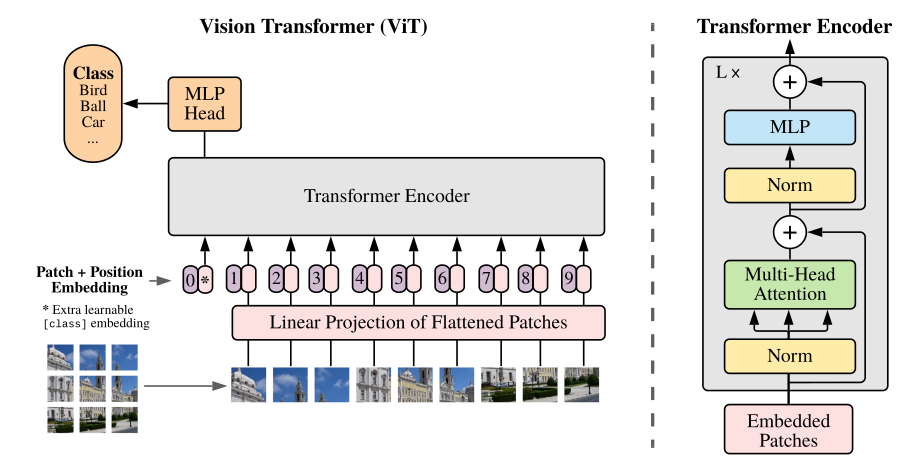                                                                                                                                                                                                                                                                                                                                                                                                           |
|:-----------------------------------------------------------------------|
| *The figure illustrates process of image classification using a transformer encoder. First, the image is divided into patches of equal size. Then, each patch is converted into a vector by a linear projection. Next, position embeddings are added to the patch vectors to preserve their spatial information. Finally, the sequence of patch vectors is fed into a standard transformer encoder to produce the image representation.* |

------------------------------------------------------------------------
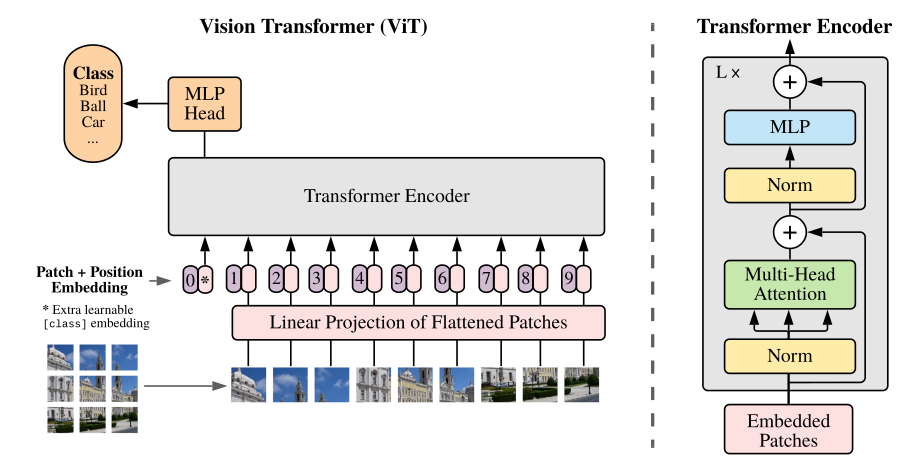

The authors show that ViT can achieve state-of-the-art results on image classification tasks, while requiring much less computational resources to train than CNNs. They also demonstrate that the key factor for the success of ViT is the scale of the pre-training dataset. When pre-trained on large-scale image datasets, such as ImageNet-21k or JFT-300M, and then fine-tuned on smaller downstream datasets, ViT attains significant improvements over previous models. The authors also conduct extensive experiments to analyze the properties and behaviors of ViT, such as its attention patterns, transferability, and robustness.

------------------------------------------------------------------------

In this paper we will reproduce the authors results to verify the claims made in the paper. Even though ViT requires less computation than CNNs, replicating the authors’ work will still cost a lot of computational resources, especially for pre-training on large-scale image datasets. Therefore, it will be better to actually use the pre-trained models available and fine-tune them in order to test the authors’ claims. The authors have released their pre-trained models and code on [GitHub](https://github.com/google-research/vision_transformer#vision-transformer-and-mlp-mixer-architectures), which can be easily adapted to different image classification tasks. By using the pre-trained models, one can save time and resources, and also benefit from the generalization and robustness of ViT. The table below shows the required resources to train each model used in the paper. The values of TPUv3-core-days indicate how many days it would take to pre-train each model on a single TPUv3 core, which is a specialized hardware accelerator for deep learning.

|      Model      | Paper-JFT (ViT-H/14) | Paper-JFT. (ViT-L/16) | Paper-I21k (ViT-L/16) | BiT-L (ResNet152x4) | Noisy Student (EfficientNet-L2) |
|:--:|:-----------:|:-----------:|:-----------:|:----------:|:-----------------:|
| TPUv3-core-days |         2.5k         |         0.68k         |         0.23k         |        9.9k         |              12.3k              |

------------------------------------------------------------------------